---

<center><h1>ADMN5015 Artificial Intelligence in Marketing</h1>
<h2>Assignment 2: Classification using Tensorflow
<h3>Katrina Ong

---

**Summary**

This project aims to classify customers who are likely to churn or not likely to churn for a tour & travel company. The dataset was obtained through [Kaggle](https://www.kaggle.com/datasets/tejashvi14/tour-travels-customer-churn-prediction). 

To build a Tensorflow classification model, the following steps are implemented in this notebook: 
1. Import Packages
2. Source the Data
3. Explore the Data
4. Prepare the Data (Feature Engineering)
5. Build and Test Tensorflow Model
6. Evaluate Tensorflow Model
7. Predict on New Cases

More details can be found in each line of code below.

**Benefits of Customer Churn Prediction**

Being able to classify customers who will churn vs. customers who will not churn allows a company to take proactive approaches in retaining customers. By know which customers will likely churn, the company can target these customers, understand their behavior, and tailor their marketing strategy accordingly.

**Communication to Management**

Effective communication to management is key in adopting machine learning methods and analytics in an organization's marketing strategy. Benefits may be communicated in terms of the value of the business that could be saved if this model is adopted. For example, the value of business lost due to customers churning can be highlighted in comparison to the prediction accuracy of the model. 

The potential savings would amount to the following:

``` Potential Savings = (Value of Business Lost x Recall Rate) - Amount of Proactive Marketing Measures Undertaken ```

*Note: Recall Rate is used since it denotes the percentage of true positives (i.e., customers who will churn) detected*

**Results**

The Tensorflow model was able to achieve the following performance metrics:
- Accuracy: 0.8348 
- Recall: 0.8039 
- Area Under the Curve (AUC): 0.8694

**Sources:** [[1]](https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed), [[2]](https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/), [[3]](https://www.analyticsvidhya.com/blog/2020/01/fundamentals-deep-learning-activation-functions-when-to-use-them/)

---

### 1) Import Packages

In [1]:
# Importing Standard packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import random
import os

from datetime import datetime, date, timedelta
import time
from time import strptime

In [2]:
# Feature Engineering Packages
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
#from feature_engine.encoding import OneHotEncoder, OrdinalEncoder
import category_encoders as ce
from sklearn.impute import KNNImputer

In [3]:
# Imbalanced learning library
from imblearn.datasets import fetch_datasets
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import (
    SMOTE,
    BorderlineSMOTE,
    SVMSMOTE,
)

from imblearn.combine import SMOTEENN, SMOTETomek

In [4]:
# Train Test Split
from sklearn.model_selection import train_test_split

In [5]:
# Tensorflow
import tensorflow as tf

In [6]:
#Classification Metrics
from sklearn import metrics

In [7]:
# Set Options for display
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.4f}'.format
sns.set_style("whitegrid")
sns.set_context("paper", font_scale = 2)

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.mode.chained_assignment = None # default='warn'

In [8]:
#Set random state
SEED = 17

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [9]:
#Set random state for tensorflow
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

[[Source]](https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed) 

---

### 2) Source the Data

In [10]:
# Source data from CSV file
df = pd.read_csv('Customertravel.csv')

In [11]:
# Preview first few records
df.head(3)

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Target
0,34,No,Middle Income,6,No,Yes,0
1,34,Yes,Low Income,5,Yes,No,1
2,37,No,Middle Income,3,Yes,No,0


In [12]:
# Preview last few records
df.tail(3)

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Target
951,37,No,Middle Income,4,No,No,0
952,30,No,Low Income,1,Yes,Yes,0
953,31,Yes,High Income,1,No,No,0


---

### 3) Explore the Data

In [13]:
# Checking the datatypes per column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954 entries, 0 to 953
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Age                         954 non-null    int64 
 1   FrequentFlyer               954 non-null    object
 2   AnnualIncomeClass           954 non-null    object
 3   ServicesOpted               954 non-null    int64 
 4   AccountSyncedToSocialMedia  954 non-null    object
 5   BookedHotelOrNot            954 non-null    object
 6   Target                      954 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 52.3+ KB


In [14]:
# Check summary statistics of numeric variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,954.0000,32.1090,3.3374,27.0000,30.0000,31.0000,35.0000,38.0000
ServicesOpted,954.0000,2.4371,1.6062,1.0000,1.0000,2.0000,4.0000,6.0000
Target,954.0000,0.2348,0.4241,0.0000,0.0000,0.0000,0.0000,1.0000


In [15]:
# Identify and check the value counts/classes of the target variable
# 1 - Customer Churn
# 0 - Customer does not churn

df["Target"].value_counts() 

0    730
1    224
Name: Target, dtype: int64

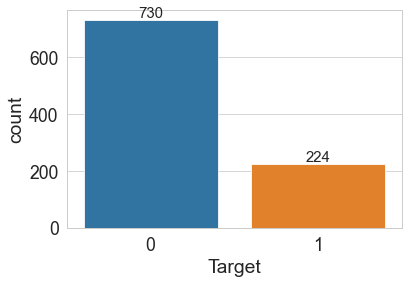

In [16]:
# Plot count of target class
plt.rcParams['font.size'] = 15
ax = sns.countplot(data = df, x = "Target")
abs_values = df['Target'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values); #imbalanced

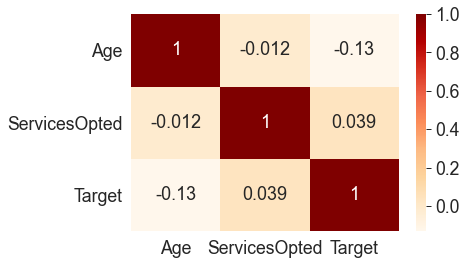

In [17]:
#Create Correlation Heatmap
sns.heatmap(df.corr(),annot = True, annot_kws={"fontsize":18}, cmap='OrRd');

In [18]:
# Creating a list of categorical variables
cat_cols = ['FrequentFlyer','AnnualIncomeClass','AccountSyncedToSocialMedia','BookedHotelOrNot']

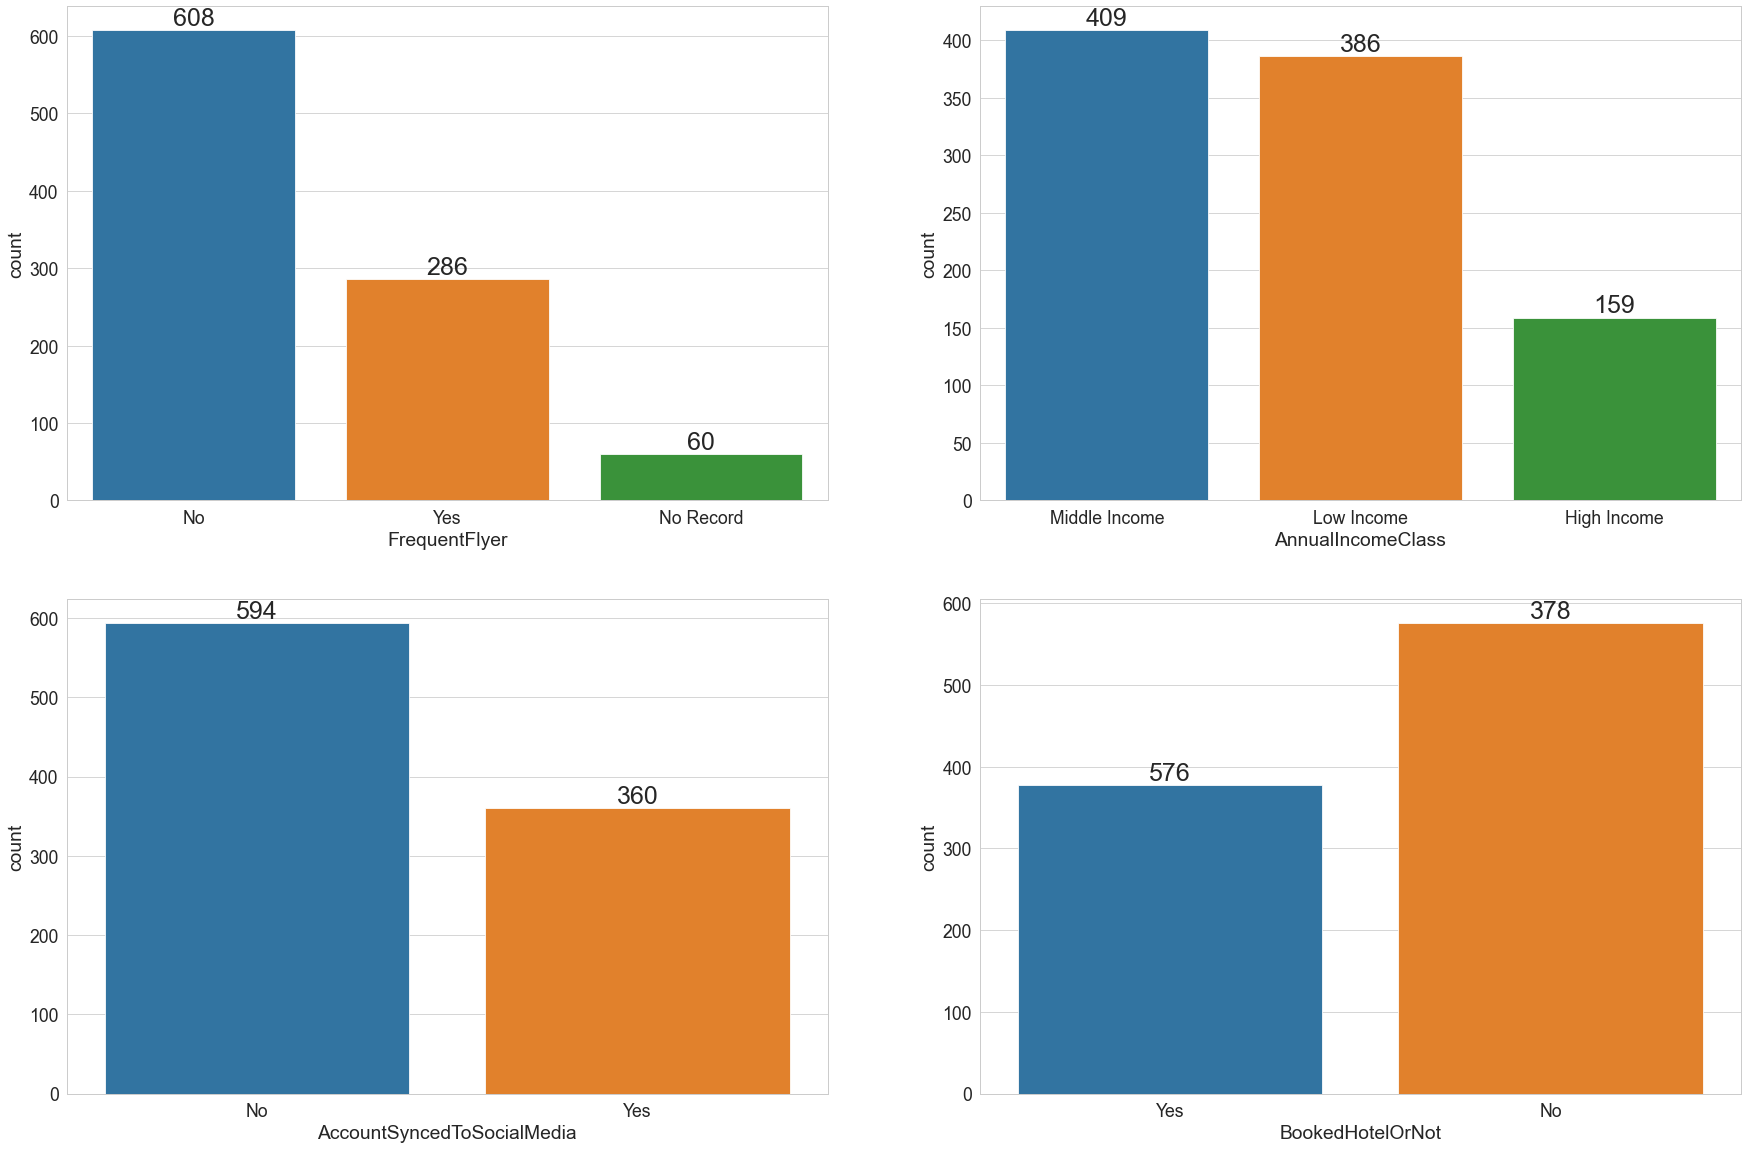

In [19]:
# Plotting the counts of values for each categorical variable 
fig,axes = plt.subplots(2,2,figsize=(30,20))
plt.rcParams['font.size'] = 25

for idx,cat_col in enumerate(cat_cols):
    row,col = idx//2,idx%2
    sns.countplot(data=df,x=cat_col,ax=axes[row,col])
    abs_values = df[cat_col].value_counts(ascending=False).values
    axes[row,col].bar_label(container=axes[row,col].containers[0], labels=abs_values)

---

### 3) Prepare the Data

#### 3a) One-Hot Encoding of Categorical Columns

In [20]:
# Define columns for one-hot encodring
onehot_cols = cat_cols.copy()

In [21]:
# Removing Annual Income Class since it is an ordinal column
onehot_cols.remove("AnnualIncomeClass")
onehot_cols

['FrequentFlyer', 'AccountSyncedToSocialMedia', 'BookedHotelOrNot']

In [22]:
# Instantiate One-Hot encoding
onehot_encoder = ce.one_hot.OneHotEncoder(cols=onehot_cols,use_cat_names = True)

In [23]:
# Fit-Transform to Dataset
df = onehot_encoder.fit_transform(df)

In [24]:
df.head(3)

,Age,FrequentFlyer_No,FrequentFlyer_Yes,FrequentFlyer_No Record,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia_No,AccountSyncedToSocialMedia_Yes,BookedHotelOrNot_Yes,BookedHotelOrNot_No,Target
0,34,1,0,0,Middle Income,6,1,0,1,0,0
1,34,0,1,0,Low Income,5,0,1,0,1,1
2,37,1,0,0,Middle Income,3,0,1,0,1,0


#### 3b) Ordinal Encoding for Ordered Categorical Columns

In [25]:
# Mapping of categories for ordinal encoding - lower number for lower rank
d_incomeClass = {'col': 'AnnualIncomeClass', 'mapping': {'Low Income': 0, 'Middle Income': 1, 'High Income': 2}}

In [26]:
# Instantiate Ordinal Encoding
ordinal_encoder = ce.ordinal.OrdinalEncoder(cols='AnnualIncomeClass',mapping = [d_incomeClass])

In [27]:
# Fit-Transform to Dataset
df = ordinal_encoder.fit_transform(df)

In [28]:
#Preview Data
df.head(3)

,Age,FrequentFlyer_No,FrequentFlyer_Yes,FrequentFlyer_No Record,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia_No,AccountSyncedToSocialMedia_Yes,BookedHotelOrNot_Yes,BookedHotelOrNot_No,Target
0,34,1,0,0,1,6,1,0,1,0,0
1,34,0,1,0,0,5,0,1,0,1,1
2,37,1,0,0,1,3,0,1,0,1,0


In [29]:
df.tail(3)

,Age,FrequentFlyer_No,FrequentFlyer_Yes,FrequentFlyer_No Record,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia_No,AccountSyncedToSocialMedia_Yes,BookedHotelOrNot_Yes,BookedHotelOrNot_No,Target
951,37,1,0,0,1,4,1,0,0,1,0
952,30,1,0,0,0,1,0,1,1,0,0
953,31,0,1,0,2,1,1,0,0,1,0


#### 3c) Remove Missing Values

In [30]:
# Remove missing values
df = df.drop(df[df['FrequentFlyer_No Record'] == 1].index)

In [31]:
# Check if records with missing values have been removed
df['FrequentFlyer_No Record'].value_counts()

0    894
Name: FrequentFlyer_No Record, dtype: int64

#### 3d) Delete Unnecessary Columns

In [32]:
# Drop No Record encoded column
df = df.drop('FrequentFlyer_No Record',axis=1)

In [33]:
# Checking datatypes and names of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 894 entries, 0 to 953
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   Age                             894 non-null    int64
 1   FrequentFlyer_No                894 non-null    int64
 2   FrequentFlyer_Yes               894 non-null    int64
 3   AnnualIncomeClass               894 non-null    int32
 4   ServicesOpted                   894 non-null    int64
 5   AccountSyncedToSocialMedia_No   894 non-null    int64
 6   AccountSyncedToSocialMedia_Yes  894 non-null    int64
 7   BookedHotelOrNot_Yes            894 non-null    int64
 8   BookedHotelOrNot_No             894 non-null    int64
 9   Target                          894 non-null    int64
dtypes: int32(1), int64(9)
memory usage: 73.3 KB


In [34]:
# List columns to delete
cols_to_delete = ['FrequentFlyer_No','AccountSyncedToSocialMedia_No','BookedHotelOrNot_No']

In [35]:
# Drop columns 
df = df.drop(cols_to_delete,axis=1)

In [36]:
# Checking if information has been deleted
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 894 entries, 0 to 953
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   Age                             894 non-null    int64
 1   FrequentFlyer_Yes               894 non-null    int64
 2   AnnualIncomeClass               894 non-null    int32
 3   ServicesOpted                   894 non-null    int64
 4   AccountSyncedToSocialMedia_Yes  894 non-null    int64
 5   BookedHotelOrNot_Yes            894 non-null    int64
 6   Target                          894 non-null    int64
dtypes: int32(1), int64(6)
memory usage: 52.4 KB


#### 3e) Visualize Cleaned Data 

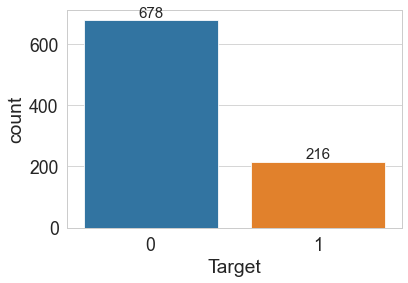

In [37]:
# Plot count of target class
plt.rcParams['font.size'] = 15
ax = sns.countplot(data = df, x = "Target")
abs_values = df['Target'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values); #imbalanced

In [38]:
# Creating a new list of categorical variables
cat_cols = ['FrequentFlyer_Yes','AnnualIncomeClass','AccountSyncedToSocialMedia_Yes','BookedHotelOrNot_Yes']

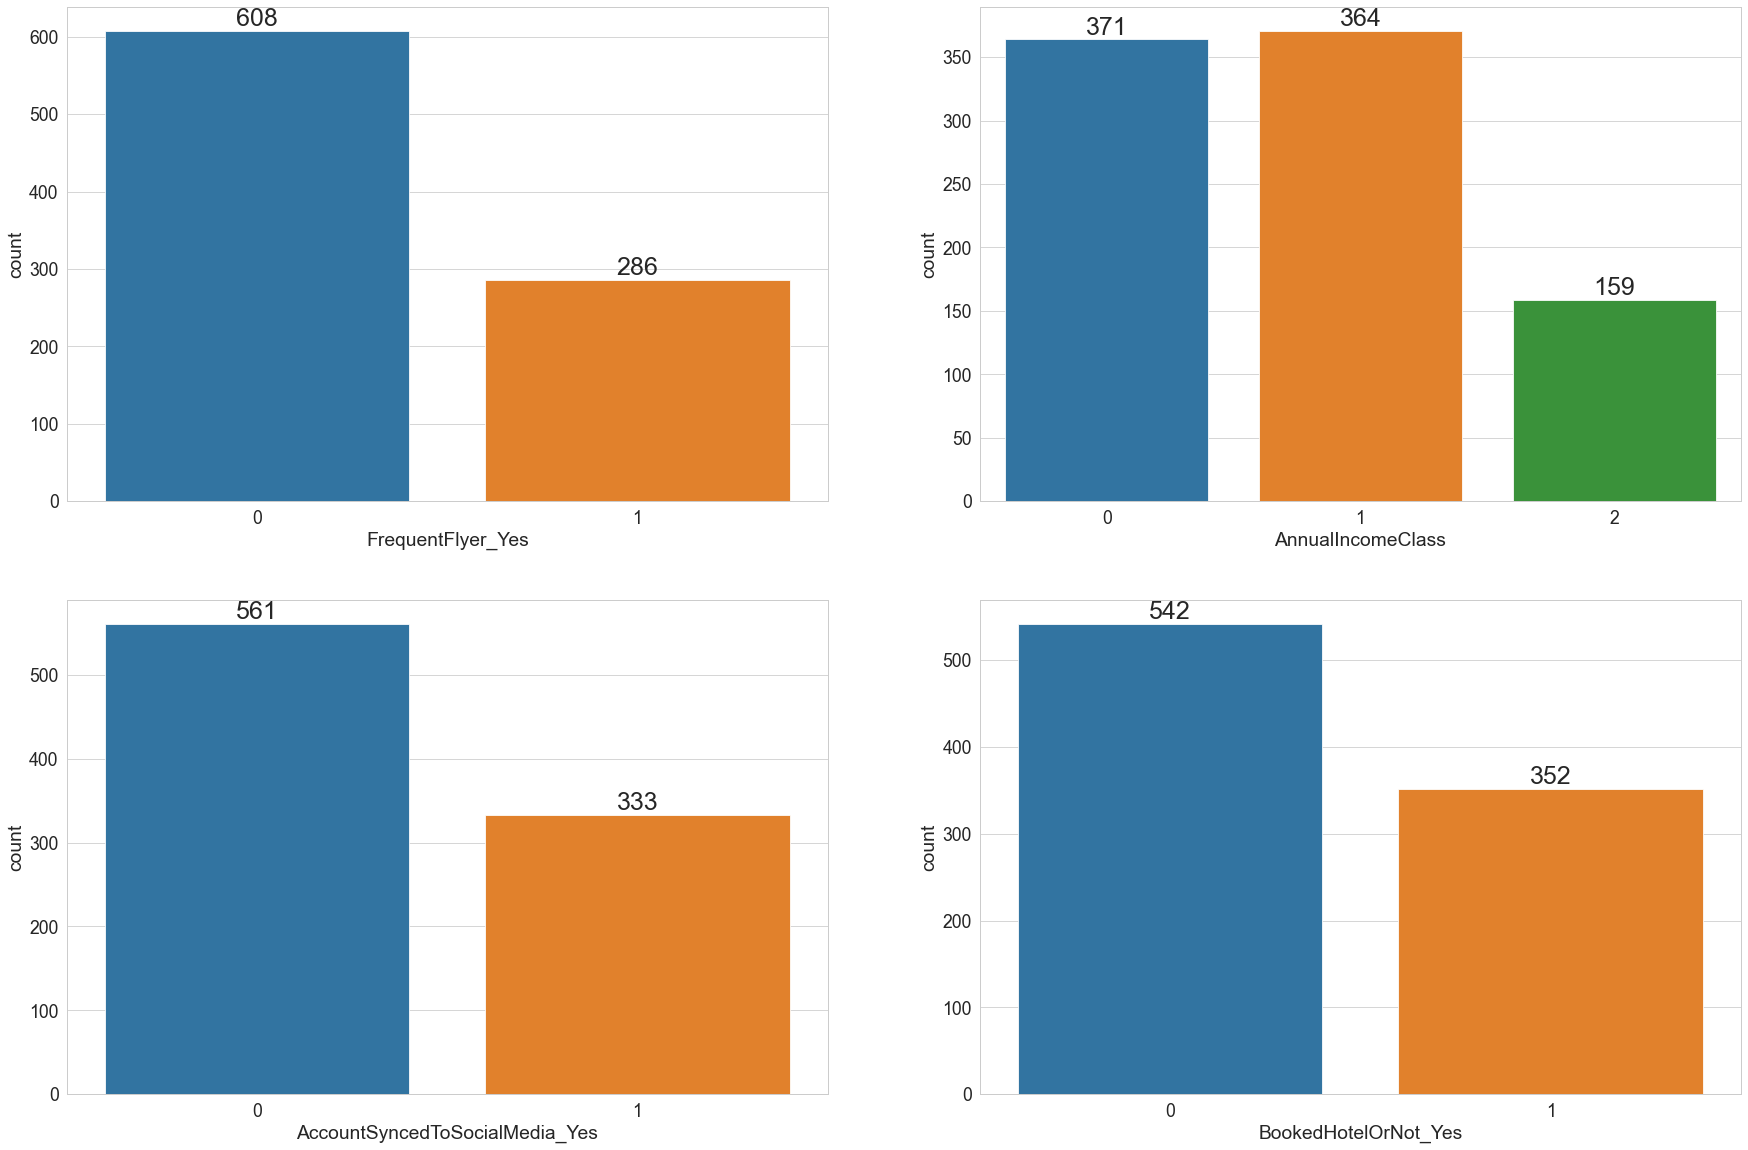

In [39]:
# Plotting the counts of values for each categorical variable 
fig,axes = plt.subplots(2,2,figsize=(30,20))
plt.rcParams['font.size'] = 25

for idx,cat_col in enumerate(cat_cols):
    row,col = idx//2,idx%2
    sns.countplot(data=df,x=cat_col,ax=axes[row,col])
    abs_values = df[cat_col].value_counts(ascending=False).values
    axes[row,col].bar_label(container=axes[row,col].containers[0], labels=abs_values)

#### 3f) Train-Test Split

In [40]:
#Separate Features from Target
X = df.drop('Target',axis=1)
y = df['Target']

In [41]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=17)

#### 3g) Resampling Imbalanced Data

In [42]:
#Instantiate SMOTE
sm = SMOTE(
    sampling_strategy='auto',  
    random_state=21,  
    k_neighbors=5,
    n_jobs=-1
)

In [43]:
#Instantiate ENN
enn = EditedNearestNeighbours(
    sampling_strategy='auto',
    n_neighbors=3,
    kind_sel='all',
    n_jobs=-1)

In [44]:
#Combine Rebalancing Methods
method = SMOTEENN(
    sampling_strategy='auto',  
    random_state=21,  
    smote=sm,
    enn=enn,
    n_jobs=-1
)

In [45]:
#Apply resampling to training data only
X_train_rs, y_train_rs = method.fit_resample(X_train,y_train)

In [46]:
y_train_rs.value_counts() #resampling improved the balance between majority class and minority class

0    505
1    369
Name: Target, dtype: int64

#### 3h) Scale the Dataset

In [47]:
# Instantiate Column Transformer to apply Standard Scaler to relevant columns and ignore/passthrough remaning date time columns
ct = ColumnTransformer([("scaler", StandardScaler(),['Age','ServicesOpted'])],
                        remainder = 'passthrough') 

In [48]:
# Fit and Transform on Training Data
X_train_sc = ct.fit_transform(X_train_rs)

In [49]:
# Transform on Test Data
X_test_sc = ct.transform(X_test)

In [50]:
# Checking the dimensions of the training and testing data
X_train_sc.shape, X_test_sc.shape, y_train_rs.shape, y_test.shape

((874, 6), (224, 6), (874,), (224,))

#### 3i) Convert to Tensorflow Objects

In [51]:
# Convert training and testing features to Tensorflow Objects 
X_train_tf = tf.convert_to_tensor(X_train_sc)
X_test_tf = tf.convert_to_tensor(X_test_sc)

---

### 4) Build and Test Tensorflow Model

In [52]:
# Define the model

def get_basic_model():
  model = tf.keras.Sequential([
    #normalizer,
    tf.keras.layers.Dense(6, activation='relu'),
    #tf.keras.layers.Dense(2, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') # Possible labels 0 or 1
  ])

  model.compile(optimizer='adam',
                #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #if output is more than 2
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #if output is 2, uncomment this
                metrics=['Accuracy','Recall','AUC'])
  
  return model

In [53]:
# Defining callback to signal the model to stop learning
callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0.0001,
    patience=30,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

In [54]:
# Train model

BATCH_SIZE = 2**8 #has to be in power of 2

model = get_basic_model()

model.fit(X_train_tf, y_train_rs, epochs=4000, batch_size=BATCH_SIZE, callbacks = [callback]);

Epoch 1/4000
4/4 [==============================] - 1s 6ms/step - loss: 0.7115 - Accuracy: 0.4302 - recall: 0.7832 - auc: 0.4497
Epoch 2/4000
4/4 [==============================] - 0s 3ms/step - loss: 0.7095 - Accuracy: 0.4279 - recall: 0.7696 - auc: 0.4549
Epoch 3/4000
4/4 [==============================] - 0s 3ms/step - loss: 0.7076 - Accuracy: 0.4394 - recall: 0.7696 - auc: 0.4589
Epoch 4/4000
4/4 [==============================] - 0s 3ms/step - loss: 0.7058 - Accuracy: 0.4233 - recall: 0.7046 - auc: 0.4588
Epoch 5/4000
4/4 [==============================] - 0s 3ms/step - loss: 0.7041 - Accuracy: 0.4256 - recall: 0.6694 - auc: 0.4684
Epoch 6/4000
4/4 [==============================] - 0s 3ms/step - loss: 0.7025 - Accuracy: 0.4394 - recall: 0.6558 - auc: 0.4734
Epoch 7/4000
4/4 [==============================] - 0s 3ms/step - loss: 0.7009 - Accuracy: 0.4439 - recall: 0.6233 - auc: 0.4788
Epoch 8/4000
4/4 [==============================] - 0s 3ms/step - loss: 0.6994 - Accuracy: 0.4508

4/4 [==============================] - 0s 8ms/step - loss: 0.5662 - Accuracy: 0.7597 - recall: 0.5745 - auc: 0.8490
Epoch 65/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.5621 - Accuracy: 0.7597 - recall: 0.5745 - auc: 0.8528
Epoch 66/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.5582 - Accuracy: 0.7597 - recall: 0.5745 - auc: 0.8546
Epoch 67/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.5540 - Accuracy: 0.7609 - recall: 0.5772 - auc: 0.8571
Epoch 68/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.5499 - Accuracy: 0.7597 - recall: 0.5772 - auc: 0.8584
Epoch 69/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.5454 - Accuracy: 0.7689 - recall: 0.6070 - auc: 0.8605
Epoch 70/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.5410 - Accuracy: 0.7700 - recall: 0.6152 - auc: 0.8627
Epoch 71/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.5364 - Accuracy: 0.7735 - rec

4/4 [==============================] - 0s 10ms/step - loss: 0.3705 - Accuracy: 0.8330 - recall: 0.7859 - auc: 0.9142
Epoch 189/4000
4/4 [==============================] - 0s 10ms/step - loss: 0.3702 - Accuracy: 0.8330 - recall: 0.7859 - auc: 0.9146
Epoch 190/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.3699 - Accuracy: 0.8330 - recall: 0.7859 - auc: 0.9149
Epoch 191/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.3696 - Accuracy: 0.8330 - recall: 0.7859 - auc: 0.9150
Epoch 192/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.3694 - Accuracy: 0.8330 - recall: 0.7859 - auc: 0.9150
Epoch 193/4000
4/4 [==============================] - 0s 10ms/step - loss: 0.3691 - Accuracy: 0.8330 - recall: 0.7859 - auc: 0.9153
Epoch 194/4000
4/4 [==============================] - 0s 11ms/step - loss: 0.3689 - Accuracy: 0.8352 - recall: 0.7859 - auc: 0.9157
Epoch 195/4000
4/4 [==============================] - 0s 10ms/step - loss: 0.3687 - Accuracy: 

4/4 [==============================] - 0s 8ms/step - loss: 0.3406 - Accuracy: 0.8398 - recall: 0.7967 - auc: 0.9282
Epoch 313/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.3405 - Accuracy: 0.8444 - recall: 0.8103 - auc: 0.9284
Epoch 314/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.3403 - Accuracy: 0.8444 - recall: 0.8103 - auc: 0.9286
Epoch 315/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.3399 - Accuracy: 0.8444 - recall: 0.8103 - auc: 0.9289
Epoch 316/4000
4/4 [==============================] - 0s 10ms/step - loss: 0.3397 - Accuracy: 0.8444 - recall: 0.8103 - auc: 0.9289
Epoch 317/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.3394 - Accuracy: 0.8444 - recall: 0.8103 - auc: 0.9290
Epoch 318/4000
4/4 [==============================] - 0s 10ms/step - loss: 0.3391 - Accuracy: 0.8444 - recall: 0.8103 - auc: 0.9290
Epoch 319/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.3388 - Accuracy: 0.8

4/4 [==============================] - 0s 9ms/step - loss: 0.3097 - Accuracy: 0.8432 - recall: 0.7995 - auc: 0.9410
Epoch 437/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.3095 - Accuracy: 0.8455 - recall: 0.8076 - auc: 0.9413
Epoch 438/4000
4/4 [==============================] - 0s 12ms/step - loss: 0.3093 - Accuracy: 0.8478 - recall: 0.8130 - auc: 0.9417
Epoch 439/4000
4/4 [==============================] - 0s 11ms/step - loss: 0.3093 - Accuracy: 0.8455 - recall: 0.8076 - auc: 0.9413
Epoch 440/4000
4/4 [==============================] - 0s 10ms/step - loss: 0.3090 - Accuracy: 0.8432 - recall: 0.7995 - auc: 0.9410
Epoch 441/4000
4/4 [==============================] - 0s 14ms/step - loss: 0.3089 - Accuracy: 0.8490 - recall: 0.8157 - auc: 0.9414
Epoch 442/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.3087 - Accuracy: 0.8627 - recall: 0.8509 - auc: 0.9418
Epoch 443/4000
4/4 [==============================] - 0s 13ms/step - loss: 0.3085 - Accuracy: 

4/4 [==============================] - 0s 8ms/step - loss: 0.2915 - Accuracy: 0.8638 - recall: 0.8509 - auc: 0.9461
Epoch 561/4000
4/4 [==============================] - 0s 6ms/step - loss: 0.2915 - Accuracy: 0.8650 - recall: 0.8509 - auc: 0.9460
Epoch 562/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.2915 - Accuracy: 0.8650 - recall: 0.8509 - auc: 0.9463
Epoch 563/4000
4/4 [==============================] - 0s 6ms/step - loss: 0.2913 - Accuracy: 0.8650 - recall: 0.8509 - auc: 0.9466
Epoch 564/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.2911 - Accuracy: 0.8650 - recall: 0.8509 - auc: 0.9465
Epoch 565/4000
4/4 [==============================] - 0s 7ms/step - loss: 0.2910 - Accuracy: 0.8650 - recall: 0.8509 - auc: 0.9463
Epoch 566/4000
4/4 [==============================] - 0s 7ms/step - loss: 0.2911 - Accuracy: 0.8650 - recall: 0.8509 - auc: 0.9460
Epoch 567/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.2907 - Accuracy: 0.865

4/4 [==============================] - 0s 7ms/step - loss: 0.2768 - Accuracy: 0.8890 - recall: 0.9051 - auc: 0.9489
Epoch 685/4000
4/4 [==============================] - 0s 7ms/step - loss: 0.2766 - Accuracy: 0.8890 - recall: 0.9051 - auc: 0.9491
Epoch 686/4000
4/4 [==============================] - 0s 6ms/step - loss: 0.2765 - Accuracy: 0.8867 - recall: 0.9051 - auc: 0.9489
Epoch 687/4000
4/4 [==============================] - 0s 7ms/step - loss: 0.2766 - Accuracy: 0.8856 - recall: 0.9051 - auc: 0.9483
Epoch 688/4000
4/4 [==============================] - 0s 7ms/step - loss: 0.2764 - Accuracy: 0.8867 - recall: 0.9051 - auc: 0.9484
Epoch 689/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.2762 - Accuracy: 0.8867 - recall: 0.9051 - auc: 0.9489
Epoch 690/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.2762 - Accuracy: 0.8867 - recall: 0.9051 - auc: 0.9486
Epoch 691/4000
4/4 [==============================] - 0s 7ms/step - loss: 0.2761 - Accuracy: 0.886

4/4 [==============================] - 0s 5ms/step - loss: 0.2653 - Accuracy: 0.9073 - recall: 0.9404 - auc: 0.9524
Epoch 809/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.2653 - Accuracy: 0.9073 - recall: 0.9404 - auc: 0.9530
Epoch 810/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.2655 - Accuracy: 0.9073 - recall: 0.9404 - auc: 0.9525
Epoch 811/4000
4/4 [==============================] - 0s 13ms/step - loss: 0.2654 - Accuracy: 0.9050 - recall: 0.9404 - auc: 0.9528
Epoch 812/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.2653 - Accuracy: 0.9027 - recall: 0.9404 - auc: 0.9525
Epoch 813/4000
4/4 [==============================] - 0s 15ms/step - loss: 0.2650 - Accuracy: 0.9073 - recall: 0.9404 - auc: 0.9528
Epoch 814/4000
4/4 [==============================] - 0s 15ms/step - loss: 0.2649 - Accuracy: 0.9027 - recall: 0.9295 - auc: 0.9528
Epoch 815/4000
4/4 [==============================] - 0s 11ms/step - loss: 0.2650 - Accuracy: 0

4/4 [==============================] - 0s 10ms/step - loss: 0.2569 - Accuracy: 0.9130 - recall: 0.9404 - auc: 0.9542
Epoch 933/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.2569 - Accuracy: 0.9119 - recall: 0.9377 - auc: 0.9542
Epoch 934/4000
4/4 [==============================] - 0s 14ms/step - loss: 0.2568 - Accuracy: 0.9119 - recall: 0.9404 - auc: 0.9541
Epoch 935/4000
4/4 [==============================] - 0s 12ms/step - loss: 0.2567 - Accuracy: 0.9130 - recall: 0.9404 - auc: 0.9541
Epoch 936/4000
4/4 [==============================] - 0s 11ms/step - loss: 0.2567 - Accuracy: 0.9130 - recall: 0.9404 - auc: 0.9544
Epoch 937/4000
4/4 [==============================] - 0s 14ms/step - loss: 0.2565 - Accuracy: 0.9119 - recall: 0.9404 - auc: 0.9548
Epoch 938/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.2566 - Accuracy: 0.9096 - recall: 0.9458 - auc: 0.9547
Epoch 939/4000
4/4 [==============================] - 0s 10ms/step - loss: 0.2565 - Accuracy:

4/4 [==============================] - 0s 9ms/step - loss: 0.2507 - Accuracy: 0.9073 - recall: 0.9458 - auc: 0.9558
Epoch 1057/4000
4/4 [==============================] - 0s 10ms/step - loss: 0.2507 - Accuracy: 0.9050 - recall: 0.9458 - auc: 0.9564
Epoch 1058/4000
4/4 [==============================] - 0s 11ms/step - loss: 0.2507 - Accuracy: 0.9005 - recall: 0.9431 - auc: 0.9558
Epoch 1059/4000
4/4 [==============================] - 0s 13ms/step - loss: 0.2504 - Accuracy: 0.9016 - recall: 0.9458 - auc: 0.9559
Epoch 1060/4000
4/4 [==============================] - 0s 11ms/step - loss: 0.2505 - Accuracy: 0.9016 - recall: 0.9458 - auc: 0.9565
Epoch 1061/4000
4/4 [==============================] - 0s 12ms/step - loss: 0.2503 - Accuracy: 0.9016 - recall: 0.9458 - auc: 0.9562
Epoch 1062/4000
4/4 [==============================] - 0s 10ms/step - loss: 0.2502 - Accuracy: 0.9005 - recall: 0.9431 - auc: 0.9559
Epoch 1063/4000
4/4 [==============================] - 0s 10ms/step - loss: 0.2500 - A

4/4 [==============================] - 0s 9ms/step - loss: 0.2415 - Accuracy: 0.9073 - recall: 0.9404 - auc: 0.9589
Epoch 1180/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.2415 - Accuracy: 0.9073 - recall: 0.9404 - auc: 0.9591
Epoch 1181/4000
4/4 [==============================] - 0s 10ms/step - loss: 0.2415 - Accuracy: 0.9096 - recall: 0.9458 - auc: 0.9592
Epoch 1182/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.2414 - Accuracy: 0.9096 - recall: 0.9458 - auc: 0.9590
Epoch 1183/4000
4/4 [==============================] - 0s 5ms/step - loss: 0.2413 - Accuracy: 0.9039 - recall: 0.9458 - auc: 0.9591
Epoch 1184/4000
4/4 [==============================] - 0s 3ms/step - loss: 0.2412 - Accuracy: 0.9016 - recall: 0.9404 - auc: 0.9591
Epoch 1185/4000
4/4 [==============================] - 0s 6ms/step - loss: 0.2412 - Accuracy: 0.9016 - recall: 0.9404 - auc: 0.9593
Epoch 1186/4000
4/4 [==============================] - 0s 7ms/step - loss: 0.2411 - Accurac

4/4 [==============================] - 0s 11ms/step - loss: 0.2334 - Accuracy: 0.9119 - recall: 0.9458 - auc: 0.9625
Epoch 1303/4000
4/4 [==============================] - 0s 11ms/step - loss: 0.2334 - Accuracy: 0.9119 - recall: 0.9458 - auc: 0.9624
Epoch 1304/4000
4/4 [==============================] - 0s 14ms/step - loss: 0.2333 - Accuracy: 0.9119 - recall: 0.9458 - auc: 0.9623
Epoch 1305/4000
4/4 [==============================] - 0s 14ms/step - loss: 0.2333 - Accuracy: 0.9119 - recall: 0.9458 - auc: 0.9626
Epoch 1306/4000
4/4 [==============================] - 0s 10ms/step - loss: 0.2332 - Accuracy: 0.9096 - recall: 0.9458 - auc: 0.9627
Epoch 1307/4000
4/4 [==============================] - 0s 10ms/step - loss: 0.2332 - Accuracy: 0.9096 - recall: 0.9458 - auc: 0.9626
Epoch 1308/4000
4/4 [==============================] - 0s 10ms/step - loss: 0.2331 - Accuracy: 0.9096 - recall: 0.9458 - auc: 0.9625
Epoch 1309/4000
4/4 [==============================] - 0s 13ms/step - loss: 0.2330 - 

4/4 [==============================] - 0s 6ms/step - loss: 0.2280 - Accuracy: 0.9085 - recall: 0.9458 - auc: 0.9644
Epoch 1425/4000
4/4 [==============================] - 0s 7ms/step - loss: 0.2280 - Accuracy: 0.9085 - recall: 0.9458 - auc: 0.9647
Epoch 1426/4000
4/4 [==============================] - 0s 6ms/step - loss: 0.2278 - Accuracy: 0.9130 - recall: 0.9566 - auc: 0.9650
Epoch 1427/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.2277 - Accuracy: 0.9130 - recall: 0.9593 - auc: 0.9648
Epoch 1428/4000
4/4 [==============================] - 0s 7ms/step - loss: 0.2281 - Accuracy: 0.9085 - recall: 0.9593 - auc: 0.9652
Epoch 1429/4000
4/4 [==============================] - 0s 6ms/step - loss: 0.2281 - Accuracy: 0.9085 - recall: 0.9593 - auc: 0.9648
Epoch 1430/4000
4/4 [==============================] - 0s 6ms/step - loss: 0.2277 - Accuracy: 0.9085 - recall: 0.9593 - auc: 0.9648
Epoch 1431/4000
4/4 [==============================] - 0s 5ms/step - loss: 0.2276 - Accuracy

4/4 [==============================] - 0s 7ms/step - loss: 0.2226 - Accuracy: 0.9176 - recall: 0.9593 - auc: 0.9673
Epoch 1549/4000
4/4 [==============================] - 0s 6ms/step - loss: 0.2225 - Accuracy: 0.9176 - recall: 0.9593 - auc: 0.9673
Epoch 1550/4000
4/4 [==============================] - 0s 5ms/step - loss: 0.2225 - Accuracy: 0.9176 - recall: 0.9593 - auc: 0.9671
Epoch 1551/4000
4/4 [==============================] - 0s 5ms/step - loss: 0.2225 - Accuracy: 0.9176 - recall: 0.9593 - auc: 0.9670
Epoch 1552/4000
4/4 [==============================] - 0s 6ms/step - loss: 0.2226 - Accuracy: 0.9130 - recall: 0.9458 - auc: 0.9670
Epoch 1553/4000
4/4 [==============================] - 0s 7ms/step - loss: 0.2227 - Accuracy: 0.9153 - recall: 0.9485 - auc: 0.9669
Epoch 1554/4000
4/4 [==============================] - 0s 6ms/step - loss: 0.2227 - Accuracy: 0.9130 - recall: 0.9485 - auc: 0.9669
Epoch 1555/4000
4/4 [==============================] - 0s 5ms/step - loss: 0.2227 - Accuracy

4/4 [==============================] - 0s 12ms/step - loss: 0.2195 - Accuracy: 0.9199 - recall: 0.9566 - auc: 0.9686
Epoch 1673/4000
4/4 [==============================] - 0s 10ms/step - loss: 0.2193 - Accuracy: 0.9188 - recall: 0.9566 - auc: 0.9686
Epoch 1674/4000
4/4 [==============================] - 0s 11ms/step - loss: 0.2192 - Accuracy: 0.9176 - recall: 0.9566 - auc: 0.9687
Epoch 1675/4000
4/4 [==============================] - 0s 12ms/step - loss: 0.2192 - Accuracy: 0.9176 - recall: 0.9566 - auc: 0.9685
Epoch 1676/4000
4/4 [==============================] - 0s 10ms/step - loss: 0.2191 - Accuracy: 0.9199 - recall: 0.9566 - auc: 0.9685
Epoch 1677/4000
4/4 [==============================] - 0s 10ms/step - loss: 0.2189 - Accuracy: 0.9165 - recall: 0.9566 - auc: 0.9686
Epoch 1678/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.2193 - Accuracy: 0.9165 - recall: 0.9566 - auc: 0.9685
Epoch 1679/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.2193 - Ac

4/4 [==============================] - 0s 9ms/step - loss: 0.2156 - Accuracy: 0.9142 - recall: 0.9512 - auc: 0.9692
Epoch 1795/4000
4/4 [==============================] - 0s 12ms/step - loss: 0.2159 - Accuracy: 0.9165 - recall: 0.9512 - auc: 0.9691
Epoch 1796/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.2158 - Accuracy: 0.9153 - recall: 0.9512 - auc: 0.9691
Epoch 1797/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.2157 - Accuracy: 0.9165 - recall: 0.9566 - auc: 0.9695
Epoch 1798/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.2157 - Accuracy: 0.9165 - recall: 0.9566 - auc: 0.9697
Epoch 1799/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.2155 - Accuracy: 0.9165 - recall: 0.9566 - auc: 0.9698
Epoch 1800/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.2154 - Accuracy: 0.9142 - recall: 0.9512 - auc: 0.9698
Epoch 1801/4000
4/4 [==============================] - 0s 7ms/step - loss: 0.2155 - Accurac

Epoch 1917/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.2117 - Accuracy: 0.9165 - recall: 0.9566 - auc: 0.9710
Epoch 1918/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.2121 - Accuracy: 0.9211 - recall: 0.9566 - auc: 0.9703
Epoch 1919/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.2119 - Accuracy: 0.9199 - recall: 0.9539 - auc: 0.9707
Epoch 1920/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.2117 - Accuracy: 0.9211 - recall: 0.9566 - auc: 0.9704
Epoch 1921/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.2117 - Accuracy: 0.9165 - recall: 0.9566 - auc: 0.9712
Epoch 1922/4000
4/4 [==============================] - 0s 10ms/step - loss: 0.2117 - Accuracy: 0.9165 - recall: 0.9566 - auc: 0.9713
Epoch 1923/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.2116 - Accuracy: 0.9165 - recall: 0.9566 - auc: 0.9716
Epoch 1924/4000
4/4 [==============================] - 0s 9ms/step - loss: 

4/4 [==============================] - 0s 10ms/step - loss: 0.2067 - Accuracy: 0.9211 - recall: 0.9566 - auc: 0.9727
Epoch 2040/4000
4/4 [==============================] - 0s 11ms/step - loss: 0.2068 - Accuracy: 0.9256 - recall: 0.9566 - auc: 0.9725
Epoch 2041/4000
4/4 [==============================] - 0s 10ms/step - loss: 0.2064 - Accuracy: 0.9245 - recall: 0.9566 - auc: 0.9727
Epoch 2042/4000
4/4 [==============================] - 0s 10ms/step - loss: 0.2062 - Accuracy: 0.9233 - recall: 0.9566 - auc: 0.9728
Epoch 2043/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.2065 - Accuracy: 0.9211 - recall: 0.9566 - auc: 0.9730
Epoch 2044/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.2061 - Accuracy: 0.9222 - recall: 0.9566 - auc: 0.9731
Epoch 2045/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.2060 - Accuracy: 0.9233 - recall: 0.9566 - auc: 0.9730
Epoch 2046/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.2060 - Accu

4/4 [==============================] - 0s 9ms/step - loss: 0.2018 - Accuracy: 0.9233 - recall: 0.9566 - auc: 0.9739
Epoch 2162/4000
4/4 [==============================] - 0s 10ms/step - loss: 0.2019 - Accuracy: 0.9233 - recall: 0.9566 - auc: 0.9739
Epoch 2163/4000
4/4 [==============================] - 0s 10ms/step - loss: 0.2019 - Accuracy: 0.9233 - recall: 0.9566 - auc: 0.9738
Epoch 2164/4000
4/4 [==============================] - 0s 10ms/step - loss: 0.2019 - Accuracy: 0.9233 - recall: 0.9566 - auc: 0.9736
Epoch 2165/4000
4/4 [==============================] - 0s 10ms/step - loss: 0.2018 - Accuracy: 0.9233 - recall: 0.9566 - auc: 0.9739
Epoch 2166/4000
4/4 [==============================] - 0s 11ms/step - loss: 0.2019 - Accuracy: 0.9233 - recall: 0.9566 - auc: 0.9739
Epoch 2167/4000
4/4 [==============================] - 0s 12ms/step - loss: 0.2018 - Accuracy: 0.9233 - recall: 0.9566 - auc: 0.9737
Epoch 2168/4000
4/4 [==============================] - 0s 12ms/step - loss: 0.2016 - A

4/4 [==============================] - 0s 9ms/step - loss: 0.1993 - Accuracy: 0.9245 - recall: 0.9593 - auc: 0.9744
Epoch 2285/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.1992 - Accuracy: 0.9245 - recall: 0.9593 - auc: 0.9745
Epoch 2286/4000
4/4 [==============================] - 0s 11ms/step - loss: 0.1989 - Accuracy: 0.9233 - recall: 0.9566 - auc: 0.9743
Epoch 2287/4000
4/4 [==============================] - 0s 11ms/step - loss: 0.1992 - Accuracy: 0.9233 - recall: 0.9566 - auc: 0.9739
Epoch 2288/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.1994 - Accuracy: 0.9256 - recall: 0.9566 - auc: 0.9740
Epoch 2289/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.1991 - Accuracy: 0.9233 - recall: 0.9566 - auc: 0.9739
Epoch 2290/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.1995 - Accuracy: 0.9245 - recall: 0.9593 - auc: 0.9736
Epoch 2291/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.1995 - Accura

4/4 [==============================] - 0s 10ms/step - loss: 0.1980 - Accuracy: 0.9245 - recall: 0.9593 - auc: 0.9741
Epoch 2347/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.1981 - Accuracy: 0.9245 - recall: 0.9593 - auc: 0.9740
Epoch 2348/4000
4/4 [==============================] - 0s 6ms/step - loss: 0.1982 - Accuracy: 0.9245 - recall: 0.9593 - auc: 0.9740
Epoch 2349/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.1981 - Accuracy: 0.9245 - recall: 0.9593 - auc: 0.9741
Epoch 2350/4000
4/4 [==============================] - 0s 9ms/step - loss: 0.1979 - Accuracy: 0.9245 - recall: 0.9593 - auc: 0.9742
Epoch 2351/4000
4/4 [==============================] - 0s 7ms/step - loss: 0.1979 - Accuracy: 0.9256 - recall: 0.9621 - auc: 0.9743
Epoch 2352/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.1981 - Accuracy: 0.9256 - recall: 0.9621 - auc: 0.9744
Epoch 2353/4000
4/4 [==============================] - 0s 10ms/step - loss: 0.1982 - Accura

4/4 [==============================] - 0s 6ms/step - loss: 0.1963 - Accuracy: 0.9268 - recall: 0.9621 - auc: 0.9745
Epoch 2471/4000
4/4 [==============================] - 0s 8ms/step - loss: 0.1963 - Accuracy: 0.9245 - recall: 0.9566 - auc: 0.9744
Epoch 2472/4000
4/4 [==============================] - 0s 7ms/step - loss: 0.1965 - Accuracy: 0.9245 - recall: 0.9566 - auc: 0.9745
Epoch 2473/4000
4/4 [==============================] - 0s 5ms/step - loss: 0.1962 - Accuracy: 0.9256 - recall: 0.9593 - auc: 0.9746
Epoch 2474/4000
4/4 [==============================] - 0s 6ms/step - loss: 0.1961 - Accuracy: 0.9268 - recall: 0.9621 - auc: 0.9745
Epoch 2475/4000
4/4 [==============================] - 0s 6ms/step - loss: 0.1963 - Accuracy: 0.9268 - recall: 0.9621 - auc: 0.9746
Epoch 2476/4000
4/4 [==============================] - 0s 4ms/step - loss: 0.1966 - Accuracy: 0.9268 - recall: 0.9621 - auc: 0.9745
Epoch 2477/4000
4/4 [==============================] - 0s 3ms/step - loss: 0.1963 - Accuracy

---

### 5) Evaluate Tensorflow Model

In [55]:
# Evaluate test data based on training data

score = model.evaluate(X_test_tf, y_test, verbose=1)

print(f'Test loss: {score[0]} / Test accuracy: {score[1]} / Test Recall: {score[2]} / Test AUC: {score[3]}')

7/7 [==============================] - 1s 4ms/step - loss: 0.4651 - Accuracy: 0.8348 - recall: 0.8039 - auc: 0.8694
Test loss: 0.4650596082210541 / Test accuracy: 0.8348214030265808 / Test Recall: 0.8039215803146362 / Test AUC: 0.8694321513175964


In [69]:
# Save model
model.save('travelchurn_model')

INFO:tensorflow:Assets written to: travelchurn_model\assets


INFO:tensorflow:Assets written to: travelchurn_model\assets


---

### 6) Predict on New Cases

In [57]:
#Create a list of columns
ind_features = list(df.columns.values).remove('Target')

In [58]:
# Create a dataframe for of 3 new cases
df_predict = pd.DataFrame(columns = ind_features)

In [59]:
#Creating new case
sample1 = {'Age': 34,
           'FrequentFlyer_Yes': 1,
           'AnnualIncomeClass': 0,
           'ServicesOpted':5,
           'AccountSyncedToSocialMedia_Yes': 1,
           'BookedHotelOrNot_Yes':0} 

In [60]:
#Creating new case
sample2 = {'Age': 45,
           'FrequentFlyer_Yes': 1,
           'AnnualIncomeClass': 2,
           'ServicesOpted':5,
           'AccountSyncedToSocialMedia_Yes': 1,
           'BookedHotelOrNot_Yes':1} 

In [61]:
#Creating new case
sample3 = {'Age': 60,
           'FrequentFlyer_Yes': 1,
           'AnnualIncomeClass': 2,
           'ServicesOpted':2,
           'AccountSyncedToSocialMedia_Yes': 0,
           'BookedHotelOrNot_Yes':1} 

In [62]:
#Add new samples to dataframe
df_predict = df_predict.append(sample1, ignore_index=True)
df_predict = df_predict.append(sample2, ignore_index=True)
df_predict = df_predict.append(sample3, ignore_index=True)


In [63]:
#Preview Dataframe
df_predict.head()

,AccountSyncedToSocialMedia_Yes,Age,AnnualIncomeClass,BookedHotelOrNot_Yes,FrequentFlyer_Yes,ServicesOpted
0,1.0000,34.0000,0.0000,0.0000,1.0000,5.0000
1,1.0000,45.0000,2.0000,1.0000,1.0000,5.0000
2,0.0000,60.0000,2.0000,1.0000,1.0000,2.0000


In [64]:
# Get List of columns
col_list = list(df_predict.columns.values)

In [65]:
# Scale Data
df_predict = ct.fit_transform(df_predict)

In [66]:
# Convert data back into a dataframe
df_predict = pd.DataFrame(df_predict, columns = col_list)

In [67]:
# Convert data to Tensorflow tensor

predict_numeric_features = tf.convert_to_tensor(df_predict)

predict_numeric_features

<tf.Tensor: shape=(3, 6), dtype=float64, numpy=
array([[-1.15738081,  0.70710678,  1.        ,  0.        ,  0.        ,
         1.        ],
       [-0.12512225,  0.70710678,  1.        ,  2.        ,  1.        ,
         1.        ],
       [ 1.28250306, -1.41421356,  0.        ,  2.        ,  1.        ,
         1.        ]])>

In [68]:
# Predict labels

class_names = ['Does not Churn', 'Churn']

predictions = model(predict_numeric_features, training=False)

# Create new columns in dataframe
df_predict['label'] = None
df_predict['certainty'] = None

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print(f"Example {i} prediction: {name} ({100*p}%)")

  # Save predictions to dataframe
  df_predict["label"].iloc[i] = name
  df_predict['certainty'].iloc[i] = format(p)

Example 0 prediction: Does not Churn (100.0%)
Example 1 prediction: Does not Churn (100.0%)
Example 2 prediction: Does not Churn (100.0%)
